# Пакеты

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
import torch.optim as optim

# Анализ данных

In [2]:
path_train = 'train.csv'

In [3]:
train = pd.read_csv(path_train)
print(train.shape)
train.head()

(29568, 3)


,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


In [4]:
train.drop('id', axis=1, inplace=True)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29568 entries, 0 to 29567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29568 non-null  object
 1   labels  29568 non-null  object
dtypes: object(2)
memory usage: 462.1+ KB


In [6]:
print('Кол-во дубликатов:', sum(train.duplicated()))
print('Кол-во пропущеных значений:\n',np.sum(train.isna()))

Кол-во дубликатов: 2114
Кол-во пропущеных значений:
 text      0
labels    0
dtype: int64


In [7]:
train.drop_duplicates(inplace=True)
print('Кол-во дубликатов:', sum(train.duplicated()))
print(train.shape)

Кол-во дубликатов: 0
(27454, 2)


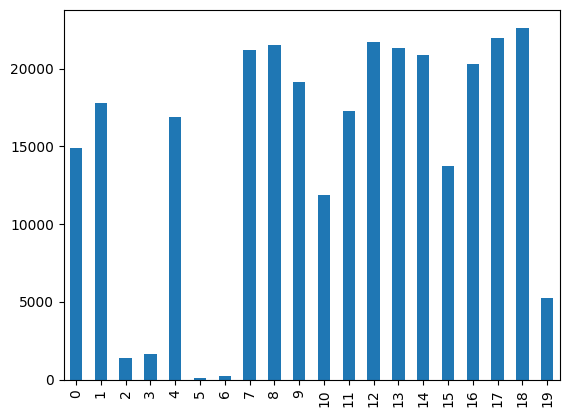

In [8]:
labels = train['labels'].str.split(expand=True).apply(pd.to_numeric)
n_class = labels.sum(axis=0)
n_class.plot(kind='bar');

In [9]:
print('Минимальное кол-во примеров класса: ', min(n_class))
print('Максимальное кол-во примеров класса:', max(n_class))

Минимальное кол-во примеров класса:  97
Максимальное кол-во примеров класса: 22649


In [10]:
print(train["text"].sample(3).values)

['PRO standup MONEY MIC\n22 марта\n«Самый энергичный комедийный формат - рубилово комиков за живые бабосики, если ты такого еще не видел, то многое пропустил!\nНо не переживай, подскажу тебе как все исправить...\nВсе предельно просто - бронируй билет и приходи: перестань откладывать жизнь на завтра, кайфуй уже сегодня\n😁\n-Пиво у нас есть,\n-Настойки есть,\n-Еда вкусная есть,\n-Комики смешные есть\nА тебя нет.\nТы нам нужен, чтобы выбрать победителя и поддержать ведущего\n💥\n»\nСтрого 18+\n⏰\nСбор гостей с 21:30, начало в 22:00\n📍\nPopravka.bar\n, Лиговский пр-кт, 50Ц (м. Пл. Восстания/Лиговский пр.)\nВход: от 500р.\n🔥\nСкидка 20% по промокоду\nFAT\nБилеты по ссылке'
 '🎭\n3 декабря в 19:00 на сцене  Дворец искусств Ленинградской области (ДК им. Горького) мистическая комедия «Чудо в большом городе»\n🤩\nТолько для подписчиков канала действует скидка 50% по промокоду: CHUDO50\n🏃\nТоропитесь приобрести билеты\n🤩\n«Чудо в большом городе» – это смешная и трогательная комедия в стиле городски

Выводы:
1. Дисбаланс классов
2. В текстах присутствуют эмодзи, жаргонизмы, URL, ники (пример: @afisha_RB), хештеги, даты и числа

# Очистка текста

## tf-idf + любая нейронная сеть

- Удалить лишнее (эмодзи, URL и тд).
- Нормализовать текст
- Удалить предлоги, указательные местоимения
- Лемматизировать слова 

In [11]:
def preprocess_tf(text):
    text = text.lower()                                        # к нижнему регистру
    
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)              # удаляет хештеги,ссылки.. 
    text = re.sub(r'\d+', '', text)                            # удаление чисел
    text = re.sub(r'[^a-zа-яё\s]', '', text)                  # убирает эмодзи и другие символы
    text = re.sub(r'\s+', ' ', text).strip()
    
    stop_words = set(stopwords.words('russian'))
    words = text.split()
    lemmatizer = MorphAnalyzer()
    words = [lemmatizer.parse(w)[0].normal_form for w in words if w not in stop_words]
    return ' '.join(words)

In [12]:
t = train["text"].sample(1).values[0]
print('Неповторимый оргиниал: \n', [t])
print('Жалкая пародия: \n', [preprocess_tf(t)])

Неповторимый оргиниал: 
 ['Спектакль Дублеры\n1 ИЮЛЯ Театр на Мельникова МОСКВА НАЧАЛО в 16:00\nЗрителю всегда интересно, что происходит за кулисами. Слухи, сплетни, зависть, ложь, любовь, измены и интриги. В результате этого гримерка превращается в бедлам, хаос переносится на сцену, а спектакль начинает жить своей, очень смешной жизнью.\nИскрящиеся юмором диалоги и непредсказуемый сюжет держат внимание до самой последней реплики, заставляют зрителя строить самые невероятные предположения.\nПродолжительность спектакля - 2 часа с антрактом.\n💲\nЦены: от 400 до 2500 руб.\n💲\nЦены со скидкой: от 200 до 1600 руб.\n‼️\nДля заказа пишите нашему менеджеру\n@menedger_koncert']
Жалкая пародия: 
 ['спектакль дублёр июль театр мельников москва начало зритель интересно происходить кулиса слух сплетня зависть ложь любовь измена интрига результат гримёрка превращаться бедлам хаос переноситься сцена спектакль начинать жить свой очень смешной жизнь искриться юмор диалог непредсказуемый сюжет держать в

## w2v + любая нейронная сеть

In [69]:
def preprocess_w2v(text):
    text = text.lower()                                        # к нижнему регистру
    
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)              # удаляет хештеги,ссылки, упоминания
    text = re.sub(r'\d+', '', text)                            # удаление чисел
    text = re.sub(r'[^a-zа-яё\s]', '', text)                   # убирает эмодзи и другие символы
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    lemmatizer = MorphAnalyzer()
    words = [lemmatizer.parse(w)[0].normal_form for w in words]
    return words

In [70]:
t = train["text"].sample(1).values[0]
print('Неповторимый оргиниал: \n', [t])
print('Жалкая пародия: \n', [preprocess_w2v(t)])

Неповторимый оргиниал: 
 ['Лагерь дневного пребывания на каникулы с 27 по 31 марта\n🚩\nДетский научный клуб\n@dnk_ufa\n«ТЕАТР в моём ДНК» -МК с профессионалами, экскурсии в театр оперы и балета, увлекательные репетиции и многое другое, горячее 4-х питание, бассейн\n💳\nСтоимость:\nсмены 5 дней 8400р\n📍\nАдрес:\nЮ.Гагарина 29/1, 89178003444\n🚩\nЦентр досуга детей и подростков "Тамыр"\nhttps://vk.com\nМК (танцы, вокал, изо, прикладное творчество, актёрское мастерство), игровые программы, коллективная творческая деятельность, экскурсия.\n💳\nСтоимость:\nучастие предполагает орг.взнос\n📍\nАдрес:\nСагита Агиша 16, +79961030582\n🚩\nАрт студия\nSchoolworkufa\n@\nschoolworkufa\nТворческие и кулинарные МК по оригами, настольные игры, квест, поход в кино, зарядка, прогулки, питание\n💳\nСтоимость:\nсмены 5 дней 7000р\nРазовое посещение: 1800₽\n📍\nАдрес\n: Верхнеторговая площадь 4, п3, офис 801\n🚩\nТалантландия\n@\ntalantlandiya\nВ программе : вкусное и сбалансированное  питание 5 раз в день, ежедне

## Встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

In [77]:
def preprocess_cnn(text):
    text = text.lower()                                        # к нижнему регистру
    
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)              # удаляет хештеги,ссылки.. 
    text = re.sub(r"[^\w\s]", " ", text)                       # убирает эмодзи и другие символы
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    lemmatizer = MorphAnalyzer()
    words = [lemmatizer.parse(w)[0].normal_form for w in words]
    return words

In [78]:
t = train["text"].sample(1).values[0]
print('Неповторимый оргиниал: \n', [t])
print('Жалкая пародия: \n', [preprocess_w2v(t)])

Неповторимый оргиниал: 
 ['🤩\n14 октября комедия «Сегодня или никогда» будет сыграна в 100-й раз!\n💥\nНа юбилейный спектакль мы подготовили особенное предложение: стоимость любого места в зале – всего 500 р.!\nФранцузский адюльтер на русской почве, история двух семей, «четырехугольник», где персонажи — муж, жена, любовник и любовница. На «вечные» вопросы о любви, верности, измене, браке и семье, в соответствии с жанром, герои пытаются ответить легко, неожиданно и с чувством юмора.\n📍\nТеатр им. В. Ф. Комиссаржевской\n🕖\n14 октября в 19:00\n🎭\nСпектакль «Сегодня или никогда» / Комедия В. Красногорова в постановке В. Глазкова\n⚡️\nАкция: лучшие места – по 500 р.\n🎫\nКупить билет:\nhttps://vk.cc/ch4jyE']
Жалкая пародия: 
 [['октябрь', 'комедия', 'сегодня', 'или', 'никогда', 'быть', 'сыграть', 'в', 'й', 'раз', 'на', 'юбилейный', 'спектакль', 'мы', 'подготовить', 'особенный', 'предложение', 'стоимость', 'любой', 'место', 'в', 'зал', 'весь', 'р', 'французский', 'адюльтер', 'на', 'русский', '

## Встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [90]:
import re
from nltk.tokenize import word_tokenize


def preprocess_r(text):
    text = text.lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) 
    text = re.sub(r'\@\w+|\#', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '<NUM>', text)  
    
    lemmatizer = MorphAnalyzer()
    tokens = word_tokenize(text)  
    words = [lemmatizer.parse(w)[0].normal_form for w in tokens]  
    return ' '.join(tokens)

## Эмбеддер + решение на bert-like моделях 

In [ ]:
def preprocess_ber(text):
    text = text.lower()  
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) 
    text = re.sub(r'\@\w+|\#', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d+', '<NUM>', text)  
    
    lemmatizer = MorphAnalyzer()
    tokens = word_tokenize(text)  
    words = [lemmatizer.parse(w)[0].normal_form for w in tokens]  
    return ' '.join(tokens)

# Обучение моделей

In [342]:
import pymorphy2 
morph = pymorphy2.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text(text, method='lemmatize'):
    text = text.lower()
    text = re.sub(r'[^a-яё]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [313]:
from sklearn.metrics import f1_score
def mean_f1_score(y_true, y_pred):
    y_pred = (y_pred > 0.5).float()
    f1 = f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), zero_division=0, average='macro')
    return torch.tensor(f1, dtype=torch.float32)

In [166]:
train['labels'] = train['labels'].apply(lambda x: [int(num) for num in x.split()])

AttributeError: 'list' object has no attribute 'split'

In [368]:
X = [preprocess_text(t) for t in tqdm(train['text'], desc="Препроцессинг train", leave= False)]
y = train['labels'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Модель 1

In [369]:
train_df = pd.DataFrame({'X_train': X_train, 'y_train': y_train})
test_df = pd.DataFrame({'X_test': X_test, 'y_test':y_test})

In [370]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
doc_freq = np.sum(X > 0, axis=0).A1
total_docs = X.shape[0]
words = np.array(vectorizer.get_feature_names_out())
mask = (doc_freq > 3) & (doc_freq < total_docs)
selected_words = set(words[mask])

tqdm.pandas()

train_df['X_train_1'] = train_df['X_train'].progress_apply(lambda x: ' '.join([word for word in x.split() if word in selected_words]))
test_df['X_test_1'] = test_df['X_test'].progress_apply(lambda x: ' '.join([word for word in x.split() if word in selected_words]))

100%|██████████| 8237/8237 [00:00<00:00, 69001.88it/s]


In [392]:
n_feature = 10000
vectorizer = TfidfVectorizer(max_features=n_feature, min_df=2)
X_train_tfidf = vectorizer.fit_transform(train_df['X_train_1'])
X_test_tfidf = vectorizer.transform(test_df['X_test_1'])

print("X_train shape: ", X_train_tfidf.shape, ", y_train shape: ", y_train.shape)
print("X_test shape: ", X_test_tfidf.shape, ", y_test shape: ", y_test.shape)

X_train shape:  (19217, 10000) , y_train shape:  (19217,)
X_test shape:  (8237, 10000) , y_test shape:  (8237,)


In [398]:
class TDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels   
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.features[idx].toarray().squeeze())
        y = torch.FloatTensor(self.labels.iloc[idx])
        return x, y
    def __len__(self):
        return len(self.labels)

train_dataset_1 = TDataset(X_train_tfidf, y_train)
val_dataset_1 = TDataset(X_test_tfidf, y_test)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=32)

batch = next(iter(train_loader_1))
print("inputs: ", batch[0].shape)  
print("labels: ", batch[1].shape)

inputs:  torch.Size([32, 10000])
labels:  torch.Size([32, 20])


In [475]:
model_1 = nn.Sequential(
    nn.Linear(X_train_tfidf.shape[1], 512),
#    nn.LayerNorm(512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
#   nn.LayerNorm(128),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
#    nn.LayerNorm(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(64, 20),
    nn.Sigmoid()
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)

Sequential(
  (0): Linear(in_features=10000, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=64, out_features=20, bias=True)
  (13): Sigmoid()
)

In [476]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=1)

In [477]:
def training(model,train_loader, train_dataset, val_loader,val_dataset,num_epochs=25,patience=3,min_delta = 0.00001):
    train_losses=[]
    val_losses = []
    train_f1s = []
    val_f1s = []
    best_val_loss = float('inf')
    counter = 0
    total_samples = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
    
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()    
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_preds.append(outputs.detach())
            all_labels.append(labels.detach())     


        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_f1 = mean_f1_score(all_labels, all_preds)
        train_f1s.append(train_f1.item())
    
        scheduler.step(epoch_loss)
    
        model.eval()
        val_running_loss = 0.0
        val_all_preds = []
        val_all_labels = []
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
            
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
                val_running_loss += loss.item() * inputs.size(0)
                val_all_preds.append(outputs)
                val_all_labels.append(labels)   

        val_epoch_loss = val_running_loss / len(val_dataset)
        val_losses.append(val_epoch_loss)
        
        val_all_preds = torch.cat(val_all_preds)
        val_all_labels = torch.cat(val_all_labels)
        val_f1 = mean_f1_score(val_all_labels, val_all_preds)
        val_f1s.append(val_f1.item())
    
        print(f'Epoch {epoch + 1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} Train F1 Score: {train_f1:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} Val F1 Score: {val_f1:.4f}')
    
        if val_epoch_loss + min_delta < best_val_loss:
            best_val_loss = val_epoch_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            print(f'EarlyStopping counter: {counter} out of {patience}')
            if counter >= patience:
                print('Early stopping triggered!')
                break
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1 Score')
    plt.plot(val_f1s, label='Validation F1 Score')
    plt.title(' F1 Score')
    plt.legend()
    plt.show()

Epoch 1/25 | Train Loss: 0.5169 Train F1 Score: 0.6365 | Val Loss: 0.3985 Val F1 Score: 0.6966
Epoch 2/25 | Train Loss: 0.3547 Train F1 Score: 0.6949 | Val Loss: 0.3096 Val F1 Score: 0.7109
Epoch 3/25 | Train Loss: 0.2943 Train F1 Score: 0.7096 | Val Loss: 0.2755 Val F1 Score: 0.7169
Epoch 4/25 | Train Loss: 0.2622 Train F1 Score: 0.7198 | Val Loss: 0.2576 Val F1 Score: 0.7199
Epoch 5/25 | Train Loss: 0.2421 Train F1 Score: 0.7288 | Val Loss: 0.2495 Val F1 Score: 0.7210
Epoch 6/25 | Train Loss: 0.2262 Train F1 Score: 0.7375 | Val Loss: 0.2403 Val F1 Score: 0.7402
Epoch 7/25 | Train Loss: 0.2136 Train F1 Score: 0.7501 | Val Loss: 0.2360 Val F1 Score: 0.7469
Epoch 8/25 | Train Loss: 0.2030 Train F1 Score: 0.7574 | Val Loss: 0.2325 Val F1 Score: 0.7468
Epoch 9/25 | Train Loss: 0.1950 Train F1 Score: 0.7623 | Val Loss: 0.2301 Val F1 Score: 0.7509
Epoch 10/25 | Train Loss: 0.1871 Train F1 Score: 0.7695 | Val Loss: 0.2289 Val F1 Score: 0.7539
Epoch 11/25 | Train Loss: 0.1794 Train F1 Score: 

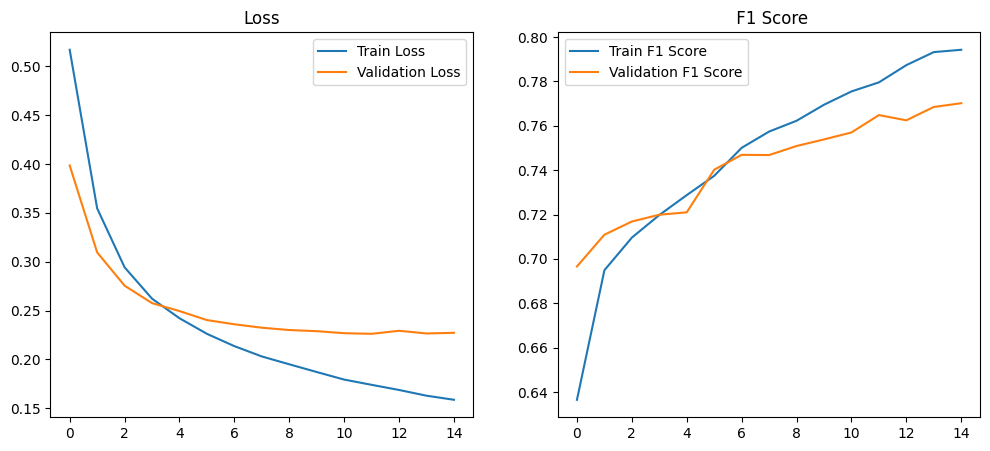

In [478]:
training(model_1,train_loader_1,train_dataset_1, val_loader_1,val_dataset_1, num_epochs=25)

In [479]:
submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
test['text'] = [preprocess_text(t) for t in tqdm(test['text'], desc="Препроцессинг", leave= False)]

In [377]:
test['text_1'] = test['text'].progress_apply(lambda x: ' '.join([word for word in x.split() if word in selected_words]))

100%|██████████| 7392/7392 [00:00<00:00, 66350.43it/s]


In [378]:
X_test_tfidf = vectorizer.transform(test['text_1'])

In [380]:
model_1_best = nn.Sequential(
    nn.Linear(X_train_tfidf.shape[1], 512),
#    nn.LayerNorm(512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
#   nn.LayerNorm(128),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    
    nn.Linear(128, 64),
  #  nn.BatchNorm1d(64),
  #  nn.LayerNorm(64),
    nn.LeakyReLU(),
 #   nn.Dropout(0.2),
    
    nn.Linear(64, 20),
    nn.Sigmoid()
)
model_1_best = model_1_best.to(device)
model_1_best.load_state_dict(torch.load('best_model.pth'))
model_1_best.eval()

Sequential(
  (0): Linear(in_features=10000, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=64, out_features=20, bias=True)
  (11): Sigmoid()
)

In [381]:
class TestDataset(Dataset):
    def __init__(self, features):
        self.features = features
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.features[idx].toarray().squeeze())
        return x 
    
    def __len__(self):
        return self.features.shape[0]

test_dataset = TestDataset(X_test_tfidf) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_outputs = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model_1_best(inputs)
        all_outputs.append(outputs.cpu())

test_outputs = torch.cat(all_outputs)

In [382]:
binary_output = (test_outputs > 0.5).int()
res = [' '.join(map(str, row.tolist())) for row in binary_output]
submission['labels'] = res
submission.to_csv('results.csv', index=False)

## Модель 2

In [71]:
tokens_train_2 = [preprocess_w2v(t) for t in tqdm(X_train, desc="Препроцессинг train", leave= False)]
tokens_test_2 = [preprocess_w2v(t) for t in tqdm(X_test, desc="Препроцессинг test", leave= False)]

Препроцессинг train:  10%|█         | 1997/19217 [04:44<51:49,  5.54it/s]

KeyboardInterrupt: 

In [116]:
from gensim.models import Word2Vec

In [122]:
vectorizer = Word2Vec(sentences=tokens_train_1, workers=8)

X_train_w2v = np.array([
    np.mean([vectorizer.wv[token] for token in tokens if token in vectorizer.wv], axis=0) 
    if any(token in vectorizer.wv for token in tokens) 
    else np.zeros(vectorizer.vector_size) 
    for tokens in tokens_train_1
])

X_test_w2v = np.array([
    np.mean([vectorizer.wv[token] for token in tokens if token in vectorizer.wv], axis=0) 
    if any(token in vectorizer.wv for token in tokens) 
    else np.zeros(vectorizer.vector_size) 
    for tokens in tokens_test_1
])

print("X_train shape:", X_train_w2v.shape, ", y_train shape:", y_train.shape)
print("X_test shape:", X_test_w2v.shape, ", y_test shape:", y_test.shape)

X_train shape: (19217, 100) , y_train shape: (19217,)
X_test shape: (8237, 100) , y_test shape: (8237,)


In [123]:
class TDataset_2(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels   
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.features[idx])
        y = torch.FloatTensor(self.labels.iloc[idx])
        return x, y
    def __len__(self):
        return len(self.labels)

train_dataset_2 = TDataset_2(X_train_w2v, y_train)
val_dataset_2 = TDataset_2(X_test_w2v, y_test)

train_loader_2 = DataLoader(train_dataset_2, batch_size=64, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=64)

batch = next(iter(train_loader_2))
print("inputs: ", batch[0].shape)  
print("labels: ", batch[1].shape)

inputs:  torch.Size([64, 100])
labels:  torch.Size([64, 20])


In [125]:
model_2 = nn.Sequential(
    nn.Linear(X_train_w2v.shape[1], 512),
    nn.LayerNorm(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 128),
    nn.LayerNorm(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(128, 64),
    nn.LayerNorm(64),
    nn.ReLU(),
    nn.Dropout(0.4),
    
    nn.Linear(64, 20),
    nn.Sigmoid()
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

Sequential(
  (0): Linear(in_features=100, out_features=512, bias=True)
  (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (10): ReLU()
  (11): Dropout(p=0.4, inplace=False)
  (12): Linear(in_features=64, out_features=20, bias=True)
  (13): Sigmoid()
)

In [126]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_2.parameters(), lr=1e-4)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Epoch 1/100 | Train Loss: 0.5692 Train F1 Score: 0.5613 | Val Loss: 0.5019 Val F1 Score: 0.5478
Epoch 2/100 | Train Loss: 0.5133 Train F1 Score: 0.5774 | Val Loss: 0.4864 Val F1 Score: 0.5662
Epoch 3/100 | Train Loss: 0.4759 Train F1 Score: 0.6032 | Val Loss: 0.4145 Val F1 Score: 0.6509
Epoch 4/100 | Train Loss: 0.4195 Train F1 Score: 0.6479 | Val Loss: 0.3792 Val F1 Score: 0.6703
Epoch 5/100 | Train Loss: 0.3998 Train F1 Score: 0.6556 | Val Loss: 0.3650 Val F1 Score: 0.6759
Epoch 6/100 | Train Loss: 0.3894 Train F1 Score: 0.6597 | Val Loss: 0.3609 Val F1 Score: 0.6764
Epoch 7/100 | Train Loss: 0.3829 Train F1 Score: 0.6639 | Val Loss: 0.3520 Val F1 Score: 0.6784
Epoch 8/100 | Train Loss: 0.3777 Train F1 Score: 0.6674 | Val Loss: 0.3489 Val F1 Score: 0.6791
Epoch 9/100 | Train Loss: 0.3730 Train F1 Score: 0.6700 | Val Loss: 0.3457 Val F1 Score: 0.6795
Epoch 10/100 | Train Loss: 0.3697 Train F1 Score: 0.6712 | Val Loss: 0.3453 Val F1 Score: 0.6803
Epoch 11/100 | Train Loss: 0.3676 Train

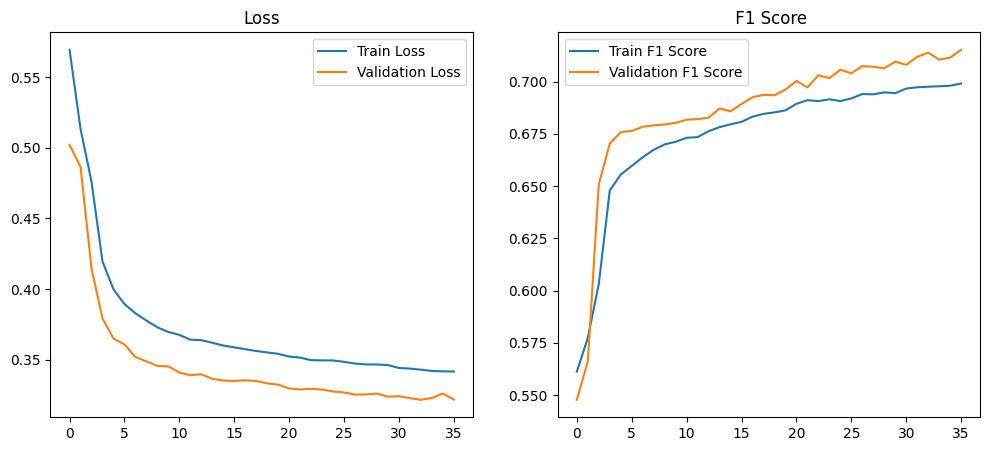

In [127]:
training(model_2,train_loader_2,train_dataset_2, val_loader_2,val_dataset_2, num_epochs=100)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

## Модель 3

In [21]:
tokens_train_3 = [preprocess_cnn(t) for t in tqdm(X_train, desc="Препроцессинг train", leave= False)]
tokens_test_3 = [preprocess_cnn(t) for t in tqdm(X_test, desc="Препроцессинг test", leave= False)]

In [110]:
from collections import Counter

def vocab(texts, min_freq=3):
    counter = Counter()
    for words in texts:
        counter.update(words)
        
    vocab = {"<pad>": 0,
             "<unk>": 1}
    sorted_words = sorted(counter.items(), key=lambda item: -item[1])
    
    idx = 2
    for word, count in sorted_words:
        if count >= min_freq:
            vocab[word] = idx
            idx += 1   
    return vocab

class TDataset_3(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.words = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.words)
    
    def __getitem__(self, idx):
        numericalized = [
            self.vocab.get(word, self.vocab["<unk>"]) 
            for word in self.words[idx]
        ]
        
        if len(numericalized) > self.max_len:
            numericalized = numericalized[:self.max_len]
        else:
            numericalized = numericalized + [self.vocab["<pad>"]] * (self.max_len - len(numericalized))
        
        X=torch.tensor(numericalized, dtype=torch.long)
        y=torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        return X,y

v_train = vocab(tokens_train_3)
v_test = vocab(tokens_test_3)

train_dataset_3 = TDataset_3(tokens_train_3, y_train, v_train, 1000)
val_dataset_3 = TDataset_3(tokens_test_3, y_test, v_test, 1000)

train_loader_3 = DataLoader(train_dataset_3, batch_size=64, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=64)

batch = next(iter(train_loader_3))
print("inputs: ", batch[0].shape)  
print("labels: ", batch[1].shape)

NameError: name 'tokens_train_3' is not defined

In [37]:
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1)

model_3 = nn.Sequential(
        nn.Embedding(len(v_train), 300),
        Permute(),
        
        nn.Conv1d(300, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.AdaptiveMaxPool1d(500), 
        
        nn.Conv1d(256, 128, kernel_size=3),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.AdaptiveMaxPool1d(1),
        nn.Flatten(),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.4),
        
        nn.Linear(64, 20),
        nn.Sigmoid()
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)

Sequential(
  (0): Embedding(21076, 300)
  (1): Permute()
  (2): Conv1d(300, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): AdaptiveMaxPool1d(output_size=500)
  (6): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): AdaptiveMaxPool1d(output_size=1)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.4, inplace=False)
  (14): Linear(in_features=64, out_features=20, bias=True)
  (15): Sigmoid()
)

In [38]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_3.parameters(), lr=1e-4)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Epoch 1/100 | Train Loss: 0.5222 Train F1 Score: 0.5866 | Val Loss: 0.4996 Val F1 Score: 0.5874
Epoch 2/100 | Train Loss: 0.4148 Train F1 Score: 0.6567 | Val Loss: 0.4680 Val F1 Score: 0.5863
Epoch 3/100 | Train Loss: 0.3685 Train F1 Score: 0.6745 | Val Loss: 0.4569 Val F1 Score: 0.5909
Epoch 4/100 | Train Loss: 0.3448 Train F1 Score: 0.6827 | Val Loss: 0.4449 Val F1 Score: 0.5951
Epoch 5/100 | Train Loss: 0.3282 Train F1 Score: 0.6906 | Val Loss: 0.4440 Val F1 Score: 0.5922
Epoch 6/100 | Train Loss: 0.3159 Train F1 Score: 0.6971 | Val Loss: 0.4354 Val F1 Score: 0.6006
Epoch 7/100 | Train Loss: 0.3052 Train F1 Score: 0.7028 | Val Loss: 0.4402 Val F1 Score: 0.5972
EarlyStopping counter: 1 out of 3
Epoch 8/100 | Train Loss: 0.2971 Train F1 Score: 0.7063 | Val Loss: 0.4487 Val F1 Score: 0.5922
EarlyStopping counter: 2 out of 3
Epoch 9/100 | Train Loss: 0.2917 Train F1 Score: 0.7105 | Val Loss: 0.4467 Val F1 Score: 0.5947
EarlyStopping counter: 3 out of 3
Early stopping triggered!


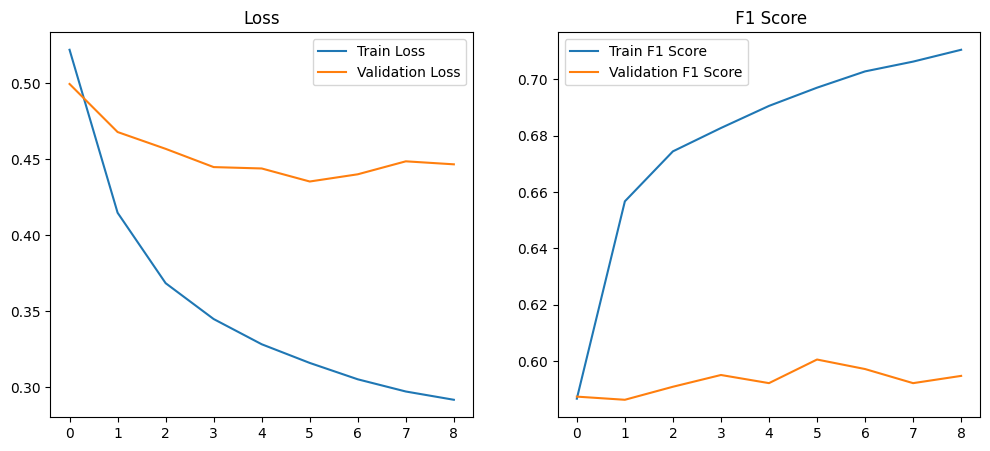

In [39]:
training(model_3,train_loader_3,train_dataset_3, val_loader_3,val_dataset_3, num_epochs=100)

In [97]:
idden, cell) = self.rnn(embedded)
        hidden = self.dropout(hidden[-1])  # Берем последний слой
        return self.fc(hidden)


In [98]:
model_4 = RNNModel()

TypeError: RNNModel.__init__() missing 6 required positional arguments: 'vocab_size', 'embed_dim', 'hidden_dim', 'output_dim', 'n_layers', and 'dropout'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='sigmoid')  # Для мультилейблинга
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Для мультилейблинга
    metrics=[tf.keras.metrics.F1Score(average='macro')]
)

## Модель 5

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text, remove_stopwords=True, lemmatize=True):

    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление HTML/XML тегов
    text = re.sub(r'<[^>]+>', '', text)
    
    # Удаление URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Удаление email
    text = re.sub(r'\S+@\S+', '', text)
    
    # Удаление упоминаний и хэштегов
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Удаление пунктуации
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Удаление чисел
    text = re.sub(r'\d+', '', text)
    
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация
    words = word_tokenize(text)
    
    # Удаление стоп-слов (если требуется)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if w not in stop_words]
    
    # Лемматизация (если требуется)
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in words]
    
    return ' '.join(words)

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import Dataset
import numpy as np
import pandas as pd

# 1. Подготовка данных
class MultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# 2. Создание модели
def create_model(num_labels):
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels,
        problem_type="multi_label_classification"
    )
    return model

# 3. Метрики
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions
    
    # Для multi-label используем порог 0.5
    preds = (torch.sigmoid(torch.Tensor(preds)) > 0.5
    preds = preds.numpy()
    
    f1_micro = f1_score(labels, preds, average='micro')
    f1_macro = f1_score(labels, preds, average='macro')
    
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
    }

# 4. Основной пайплайн
def bert_multilabel_pipeline(df, text_col, label_cols, test_size=0.2, max_len=128, batch_size=16, epochs=3):
    # Разделение данных
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df[text_col].values,
        df[label_cols].values,
        test_size=test_size
    )
    
    # Инициализация токенизатора
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Создание датасетов
    train_dataset = MultiLabelDataset(train_texts, train_labels, tokenizer, max_len)
    val_dataset = MultiLabelDataset(val_texts, val_labels, tokenizer, max_len)
    
    # Создание модели
    model = create_model(len(label_cols))
    
    # Аргументы обучения
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )
    
    # Тренер
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Обучение
    trainer.train()
    
    # Оценка
    results = trainer.evaluate()
    print(f"Final metrics: {results}")
    
    return trainer, tokenizer

# Пример использования
if __name__ == "__main__":
    # Пример данных (замените на свои)
    data = {
        'text': [
            "This is a positive review about technology",
            "Negative experience with customer service",
            "Mixed feelings about the product quality",
            "Absolutely loved the design and features"
        ],
        'label_positive': [1, 0, 0, 1],
        'label_negative': [0, 1, 1, 0],
        'label_neutral': [0, 0, 1, 0]
    }
    df = pd.DataFrame(data)
    
    # Запуск пайплайна
    label_cols = ['label_positive', 'label_negative', 'label_neutral']
    trainer, tokenizer = bert_multilabel_pipeline(df, 'text', label_cols)
    
    # Предсказание на новых данных
    def predict(text, trainer, tokenizer, max_len=128):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids = encoding['input_ids'].to(trainer.model.device)
        attention_mask = encoding['attention_mask'].to(trainer.model.device)
        
        with torch.no_grad():
            outputs = trainer.model(input_ids, attention_mask=attention_mask)
        
        preds = torch.sigmoid(outputs.logits).cpu().numpy()[0]
        return preds
    
    test_text = "I really dislike the interface but the performance is great"
    predictions = predict(test_text, trainer, tokenizer)
    print(f"Predictions: {predictions}")